# ResNet 구현

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
np.random.seed(7777)
tf.random.set_seed(7777)

### ResNet

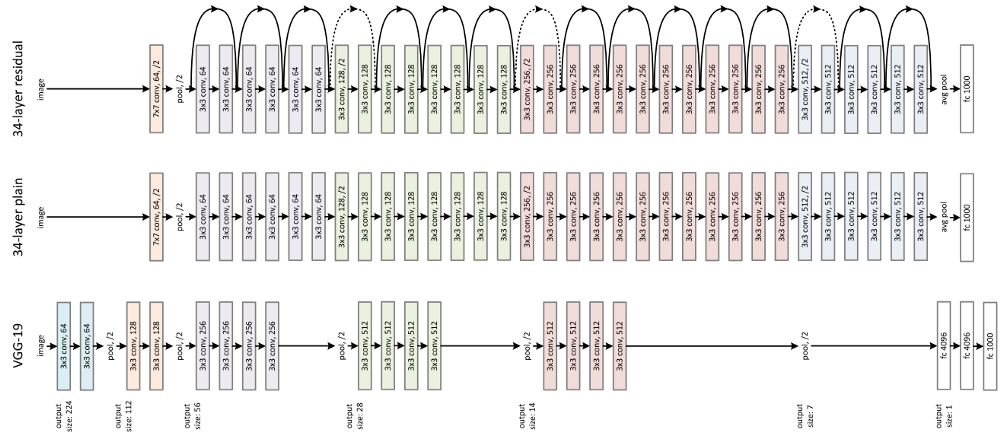

#### ResNet의 핵심은 Skip Connection

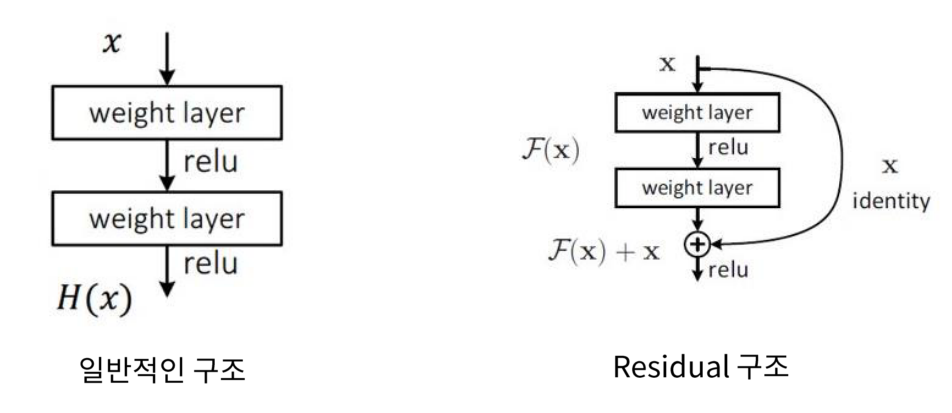

## Functional API
- tf.keras.Sequential 보다 더 유연하게 모델을 정의 할 수 있는 방법

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [6]:
def build_resnet(input_shape):
    inputs = Input(input_shape)
    
    net = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1) 
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net1_1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1) 
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation='softmax')(net)
    
    model = tf.keras.Model(inputs=inputs, outputs=net)
    
    return model

In [7]:
model= build_resnet((32,32,3))

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 32)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     2112        ['max_pooling2d[0][0]']          
                                                                                              

### Clfar10 dataset을 이용해 학습해보기

In [9]:
class DataLoader():
    
    def __init__(self):
        (self.train_x, self.train_y),(self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        
    def validate_pixel_scale(self, x):
        return 255 >= x.max() and 0 <= x.min()
    
    def scale(self, x):
        return (x / 255.0).astype(np.float32)
    
    def preprocess_dataset(self, dataset):
        feature, target = dataset
        
        validated_x = np.array([x for x in feature if self.validate_pixel_scale(x)])
        validated_y = np.array([y for x, y in zip(feature, target) if self.validate_pixel_scale(x)])
        
        # scale
        scaled_x = np.array([self.scale(x) for x in validated_x])
    
        # label encoding
        ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_y])
        
        return scaled_x, np.squeeze(ohe_y, axis=1)
    
    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))
    
    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [10]:
loader = DataLoader()

train_x, train_y = loader.get_train_dataset()

test_x, test_y = loader.get_train_dataset()

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 10)
(50000, 10)


In [11]:
lr = 0.03
opt = tf.keras.optimizers.Adam(lr)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [12]:
hist = model.fit(train_x, train_y, epochs=1, batch_size=128, validation_data=(test_x, test_y))

391/391 [==============================] - 49s 122ms/step - loss: 2.4849 - accuracy: 0.0998 - val_loss: 2.3034 - val_accuracy: 0.1000
